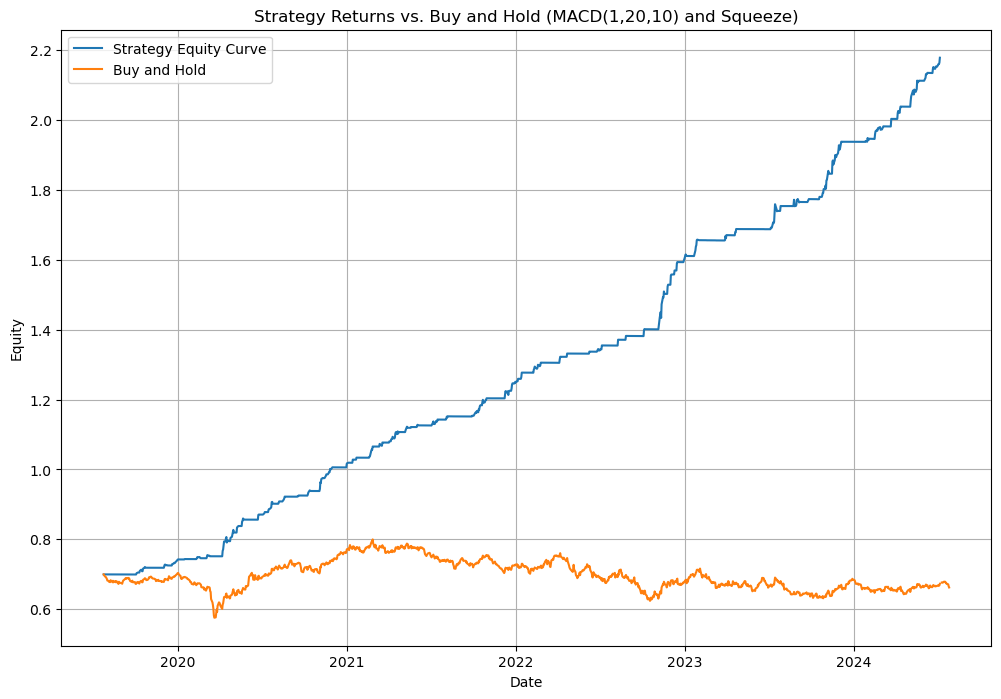

,Open,High,Low,Close,Adj Close,Volume,ShortEMA,LongEMA,MACD,Signal,Middle Band,Upper Band,Lower Band,Bandwidth,Squeeze,Position,Equity
Date,,,,,,,,,,,,,,,,,
2019-07-25,0.697812,0.698714,0.695202,0.697934,0.697934,0.0,0.697934,0.699569,-0.001635,-0.000297,NaN,NaN,NaN,NaN,False,-1,0.699671
2019-07-26,0.695072,0.695701,0.690450,0.695217,0.695217,0.0,0.695217,0.699154,-0.003937,-0.000959,NaN,NaN,NaN,NaN,False,0,0.699671
2019-07-29,0.690703,0.691802,0.689722,0.690622,0.690622,0.0,0.690622,0.698342,-0.007720,-0.002188,NaN,NaN,NaN,NaN,False,0,0.699671
2019-07-30,0.689893,0.691085,0.686950,0.689941,0.689941,0.0,0.689941,0.697542,-0.007601,-0.003172,NaN,NaN,NaN,NaN,False,0,0.699671
2019-07-31,0.687380,0.690084,0.686351,0.687522,0.687522,0.0,0.687522,0.696587,-0.009065,-0.004244,NaN,NaN,NaN,NaN,False,0,0.699671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18,0.673070,0.674400,0.671620,0.673070,0.673070,0.0,0.673070,0.671086,0.001984,0.004610,NaN,NaN,NaN,NaN,False,0,NaN
2024-07-19,0.670550,0.670800,0.668430,0.670550,0.670550,0.0,0.670550,0.671035,-0.000485,0.003683,0.674551,0.677556,0.671546,0.008909,False,0,NaN
2024-07-22,0.669631,0.669613,0.663190,0.669631,0.669631,0.0,0.669631,0.670902,-0.001271,0.002783,0.674048,0.677849,0.670247,0.011277,False,0,NaN


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Load data from CSV
def load_data(csv_file):
    data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
    return data

# Calculate MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_period, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    data['Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
    return data

# Calculate Bollinger Bands for Squeeze Indicator
def calculate_squeeze(data, bb_period=20, bb_k=2):
    data['Middle Band'] = data['Close'].rolling(window=bb_period).mean()
    data['Upper Band'] = data['Middle Band'] + bb_k * data['Close'].rolling(window=bb_period).std()
    data['Lower Band'] = data['Middle Band'] - bb_k * data['Close'].rolling(window=bb_period).std()
    data['Bandwidth'] = (data['Upper Band'] - data['Lower Band']) / data['Middle Band']
    data['Squeeze'] = data['Bandwidth'] < data['Bandwidth'].rolling(window=bb_period).mean()
    return data

# Apply trading strategy based on MACD and Squeeze Indicator
def apply_strategy(data, trade_cost_rate=0.0005):
    position = 0
    signals = []
    cash = 0
    equity = data['Close'].iloc[0]
    equity_curve = []  # Start equity list without initial equity

    for i in range(1, len(data)):
        if data['MACD'].iloc[i] > data['Signal'].iloc[i] and data['MACD'].iloc[i-1] <= data['Signal'].iloc[i-1] and data['Squeeze'].iloc[i]:
            signals.append(1)  # Buy signal
            position = 1
            cash -= equity * trade_cost_rate
        elif data['MACD'].iloc[i] < data['Signal'].iloc[i] and data['MACD'].iloc[i-1] >= data['Signal'].iloc[i-1]:
            signals.append(-1)  # Sell signal
            position = 0
            cash -= equity * trade_cost_rate
        else:
            signals.append(0)  # No signal
        
        equity = equity * (1 + (position * (data['Close'].iloc[i] - data['Close'].iloc[i-1]) / data['Close'].iloc[i-1]))
        equity_curve.append(equity + cash)
    
    result = data.iloc[1:].copy()  # align the lengths and create a copy to avoid SettingWithCopyWarning
    result['Position'] = signals
    result['Equity'] = equity_curve
    return result

# Plot results
def plot_results(data, strategy_name):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Equity'], label='Strategy Equity Curve')
    plt.plot((data['Close'] / data['Close'].iloc[0]) * data['Equity'].iloc[0], label='Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.title(f'Strategy Returns vs. Buy and Hold ({strategy_name})')
    plt.grid(True)
    plt.show()

def run_strategy(csv_file, short_period=12, long_period=26, signal_period=9, bb_period=20, bb_k=2, trade_cost_rate=0.0005):
    data = load_data(csv_file)
    data = calculate_macd(data, short_period=short_period, long_period=long_period, signal_period=signal_period)
    data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'MACD({short_period},{long_period},{signal_period}) and Squeeze')
    return data

# Optimization method
def optimize_strategy(csv_file, short_period_range, long_period_range, signal_period_range, bb_period_range, bb_k_range, trade_cost_rate=0.0005, top_n=5):
    results = []
    csv_data = load_data(csv_file)
    
    for short_period, long_period, signal_period, bb_period, bb_k in product(short_period_range, long_period_range, signal_period_range, bb_period_range, bb_k_range):
        data = csv_data.copy()
        data = calculate_macd(data, short_period=short_period, long_period=long_period, signal_period=signal_period)
        data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
        data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
        final_equity = data['Equity'].iloc[-1]
        results.append((short_period, long_period, signal_period, bb_period, bb_k, final_equity))

    # Sort results by final equity
    results.sort(key=lambda x: x[5], reverse=True)
    top_results = results[:top_n]

    # Print top results
    print("Top Optimization Results:")
    for result in top_results:
        print(f"Short Period: {result[0]}, Long Period: {result[1]}, Signal Period: {result[2]}, "
              f"BB Period: {result[3]}, BB k: {result[4]}, Final Equity: {result[5]:.2f}")

    # Plot the best result
    best_params = top_results[0]
    data = csv_data.copy()
    data = calculate_macd(data, short_period=best_params[0], long_period=best_params[1], signal_period=best_params[2])
    data = calculate_squeeze(data, bb_period=best_params[3], bb_k=best_params[4])
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'Best Params: MACD({best_params[0]},{best_params[1]},{best_params[2]}) and Squeeze({best_params[3]},{best_params[4]})')

# Example usage
csv_file_path = 'AUDUSD.csv'

# Running optimization with specified step sizes
run_strategy(csv_file_path, short_period=1, long_period=20, signal_period=10, bb_period=10, bb_k=1.5, trade_cost_rate=0.0001)


Top Optimization Results:
BB Period: 50, BB k: 1.5, Final Equity: nan
BB Period: 50, BB k: 2, Final Equity: nan
BB Period: 50, BB k: 2.5, Final Equity: nan
BB Period: 50, BB k: 3, Final Equity: nan
BB Period: 55, BB k: 1.5, Final Equity: nan


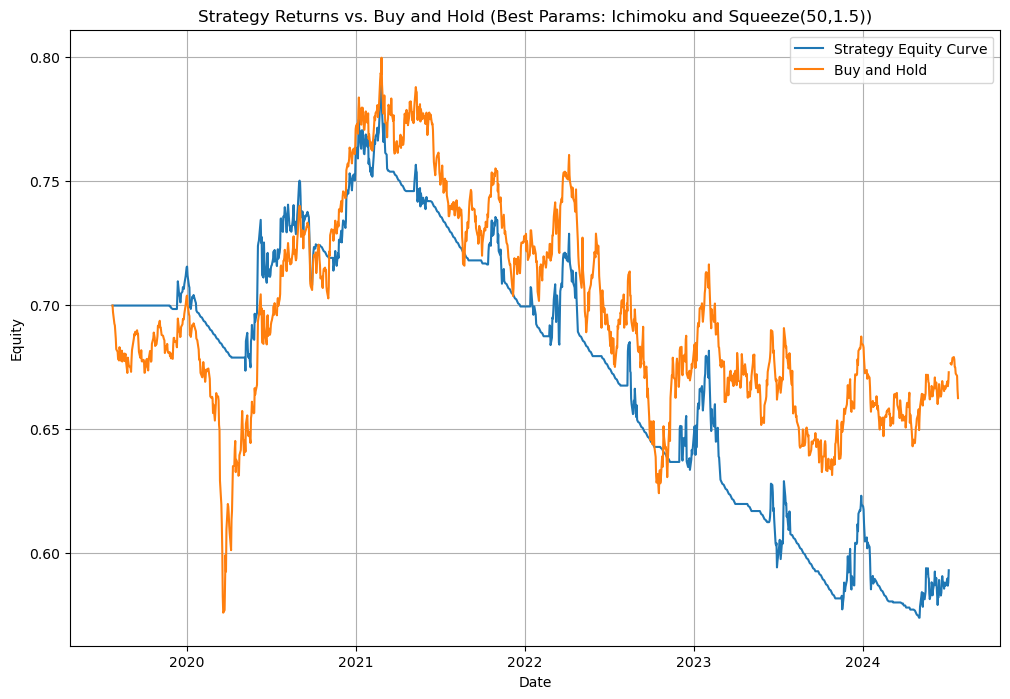

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Load data from CSV
def load_data(csv_file):
    data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
    return data

# Calculate Ichimoku Cloud components
def calculate_ichimoku(data):
    high_9 = data['High'].rolling(window=9).max()
    low_9 = data['Low'].rolling(window=9).min()
    high_26 = data['High'].rolling(window=26).max()
    low_26 = data['Low'].rolling(window=26).min()
    high_52 = data['High'].rolling(window=52).max()
    low_52 = data['Low'].rolling(window=52).min()

    data['Tenkan-sen'] = (high_9 + low_9) / 2  # Conversion line
    data['Kijun-sen'] = (high_26 + low_26) / 2  # Base line
    data['Senkou Span A'] = ((data['Tenkan-sen'] + data['Kijun-sen']) / 2).shift(26)  # Leading span A
    data['Senkou Span B'] = ((high_52 + low_52) / 2).shift(26)  # Leading span B
    data['Chikou Span'] = data['Close'].shift(-26)  # Lagging span
    return data

# Calculate Bollinger Bands for Squeeze Indicator
def calculate_squeeze(data, bb_period=20, bb_k=2):
    data['Middle Band'] = data['Close'].rolling(window=bb_period).mean()
    data['Upper Band'] = data['Middle Band'] + bb_k * data['Close'].rolling(window=bb_period).std()
    data['Lower Band'] = data['Middle Band'] - bb_k * data['Close'].rolling(window=bb_period).std()
    data['Bandwidth'] = (data['Upper Band'] - data['Lower Band']) / data['Middle Band']
    data['Squeeze'] = data['Bandwidth'] < data['Bandwidth'].rolling(window=bb_period).mean()
    return data

# Apply trading strategy based on Squeeze Indicator and Ichimoku Cloud
def apply_strategy(data, trade_cost_rate=0.0005):
    position = 0
    signals = []
    cash = 0
    equity = data['Close'].iloc[0]
    equity_curve = []  # Start equity list without initial equity

    for i in range(1, len(data)):
        in_cloud = data['Close'].iloc[i] > data['Senkou Span A'].iloc[i] and data['Close'].iloc[i] > data['Senkou Span B'].iloc[i]
        buy_condition = in_cloud and data['Tenkan-sen'].iloc[i] > data['Kijun-sen'].iloc[i] and data['Squeeze'].iloc[i]
        sell_condition = data['Close'].iloc[i] < data['Senkou Span A'].iloc[i] and data['Close'].iloc[i] < data['Senkou Span B'].iloc[i] and data['Tenkan-sen'].iloc[i] < data['Kijun-sen'].iloc[i]
        
        if buy_condition:
            signals.append(1)  # Buy signal
            position = 1
            cash -= equity * trade_cost_rate
        elif sell_condition:
            signals.append(-1)  # Sell signal
            position = 0
            cash -= equity * trade_cost_rate
        else:
            signals.append(0)  # No signal
        
        equity = equity * (1 + (position * (data['Close'].iloc[i] - data['Close'].iloc[i-1]) / data['Close'].iloc[i-1]))
        equity_curve.append(equity + cash)
    
    result = data.iloc[1:].copy()  # align the lengths and create a copy to avoid SettingWithCopyWarning
    result['Position'] = signals
    result['Equity'] = equity_curve
    return result

# Plot results
def plot_results(data, strategy_name):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Equity'], label='Strategy Equity Curve')
    plt.plot((data['Close'] / data['Close'].iloc[0]) * data['Equity'].iloc[0], label='Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.title(f'Strategy Returns vs. Buy and Hold ({strategy_name})')
    plt.grid(True)
    plt.show()

def run_strategy(csv_file, bb_period=20, bb_k=2, trade_cost_rate=0.0005):
    data = load_data(csv_file)
    data = calculate_ichimoku(data)
    data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'Ichimoku and Squeeze')
    return data

# Optimization method
def optimize_strategy(csv_file, bb_period_range, bb_k_range, trade_cost_rate=0.0005, top_n=5):
    results = []
    csv_data = load_data(csv_file)
    
    for bb_period, bb_k in product(bb_period_range, bb_k_range):
        data = csv_data.copy()
        data = calculate_ichimoku(data)
        data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
        data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
        final_equity = data['Equity'].iloc[-1]
        results.append((bb_period, bb_k, final_equity))

    # Sort results by final equity
    results.sort(key=lambda x: x[2], reverse=True)
    top_results = results[:top_n]

    # Print top results
    print("Top Optimization Results:")
    for result in top_results:
        print(f"BB Period: {result[0]}, BB k: {result[1]}, Final Equity: {result[2]:.2f}")

    # Plot the best result
    best_params = top_results[0]
    data = csv_data.copy()
    data = calculate_ichimoku(data)
    data = calculate_squeeze(data, bb_period=best_params[0], bb_k=best_params[1])
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'Best Params: Ichimoku and Squeeze({best_params[0]},{best_params[1]})')

# Example usage
csv_file_path = 'AUDUSD.csv'

# Running optimization with specified ranges
optimize_strategy(csv_file_path, 
                  bb_period_range=range(50, 200, 5),  # Step size 5
                  bb_k_range=[1.5, 2, 2.5, 3])  # Specific values


Top Optimization Results:
BB Period: 10, BB k: 1.5, ATR Period: 10, ATR Threshold: 10, Final Equity: nan
BB Period: 10, BB k: 1.5, ATR Period: 10, ATR Threshold: 14, Final Equity: nan
BB Period: 10, BB k: 1.5, ATR Period: 10, ATR Threshold: 20, Final Equity: nan
BB Period: 10, BB k: 1.5, ATR Period: 15, ATR Threshold: 10, Final Equity: nan
BB Period: 10, BB k: 1.5, ATR Period: 15, ATR Threshold: 14, Final Equity: nan


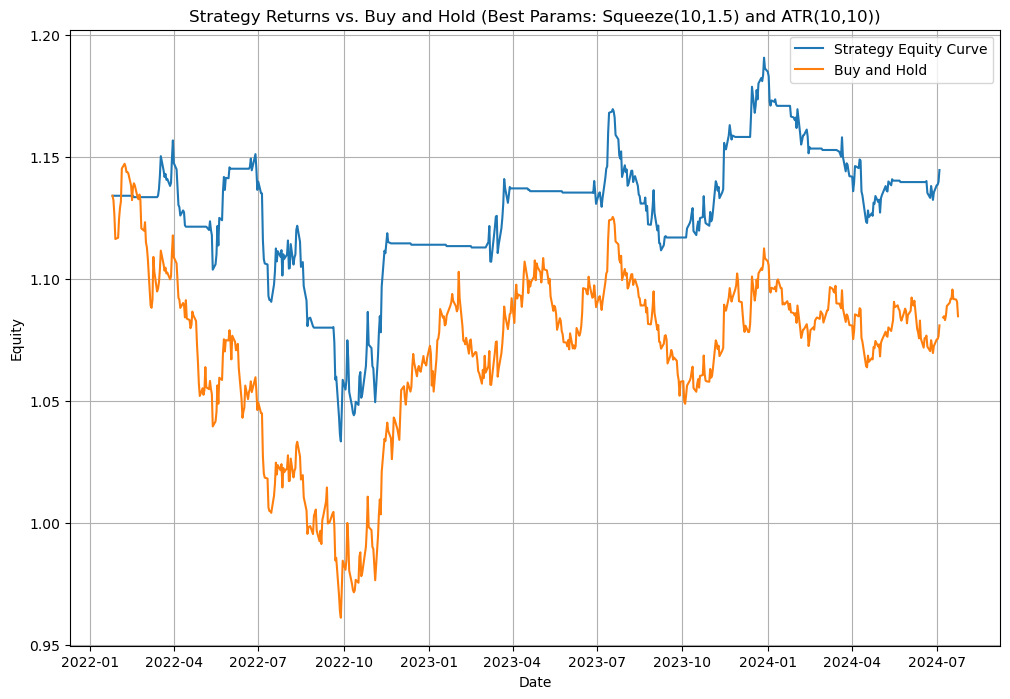

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Load data from CSV
def load_data(csv_file):
    data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
    return data

# Calculate ATR
def calculate_atr(data, period=14):
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=period).mean()
    return data

# Calculate Bollinger Bands for Squeeze Indicator
def calculate_squeeze(data, bb_period=20, bb_k=2):
    data['Middle Band'] = data['Close'].rolling(window=bb_period).mean()
    data['Upper Band'] = data['Middle Band'] + bb_k * data['Close'].rolling(window=bb_period).std()
    data['Lower Band'] = data['Middle Band'] - bb_k * data['Close'].rolling(window=bb_period).std()
    data['Bandwidth'] = (data['Upper Band'] - data['Lower Band']) / data['Middle Band']
    data['Squeeze'] = data['Bandwidth'] < data['Bandwidth'].rolling(window=bb_period).mean()
    return data

# Apply trading strategy based on Squeeze Indicator and ATR
def apply_strategy(data, trade_cost_rate=0.0005, atr_threshold=14):
    position = 0
    signals = []
    cash = 0
    equity = data['Close'].iloc[0]
    equity_curve = []  # Start equity list without initial equity

    for i in range(1, len(data)):
        buy_condition = not data['Squeeze'].iloc[i-1] and data['Squeeze'].iloc[i] and data['ATR'].iloc[i] > data['ATR'].rolling(window=atr_threshold).mean().iloc[i]
        sell_condition = not data['Squeeze'].iloc[i-1] and data['Squeeze'].iloc[i] and data['ATR'].iloc[i] < data['ATR'].rolling(window=atr_threshold).mean().iloc[i]
        
        if buy_condition:
            signals.append(1)  # Buy signal
            position = 1
            cash -= equity * trade_cost_rate
        elif sell_condition:
            signals.append(-1)  # Sell signal
            position = 0
            cash -= equity * trade_cost_rate
        else:
            signals.append(0)  # No signal
        
        equity = equity * (1 + (position * (data['Close'].iloc[i] - data['Close'].iloc[i-1]) / data['Close'].iloc[i-1]))
        equity_curve.append(equity + cash)
    
    result = data.iloc[1:].copy()  # align the lengths and create a copy to avoid SettingWithCopyWarning
    result['Position'] = signals
    result['Equity'] = equity_curve
    return result

# Plot results
def plot_results(data, strategy_name):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Equity'], label='Strategy Equity Curve')
    plt.plot((data['Close'] / data['Close'].iloc[0]) * data['Equity'].iloc[0], label='Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.title(f'Strategy Returns vs. Buy and Hold ({strategy_name})')
    plt.grid(True)
    plt.show()

def run_strategy(csv_file, bb_period=20, bb_k=2, atr_period=14, atr_threshold=14, trade_cost_rate=0.0005):
    data = load_data(csv_file)
    data = calculate_atr(data, period=atr_period)
    data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate, atr_threshold=atr_threshold)
    plot_results(data, f'Squeeze and ATR')
    return data

# Optimization method
def optimize_strategy(csv_file, bb_period_range, bb_k_range, atr_period_range, atr_threshold_range, trade_cost_rate=0.0005, top_n=5):
    results = []
    csv_data = load_data(csv_file)
    
    for bb_period, bb_k, atr_period, atr_threshold in product(bb_period_range, bb_k_range, atr_period_range, atr_threshold_range):
        data = csv_data.copy()
        data = calculate_atr(data, period=atr_period)
        data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
        data = apply_strategy(data, trade_cost_rate=trade_cost_rate, atr_threshold=atr_threshold)
        final_equity = data['Equity'].iloc[-1]
        results.append((bb_period, bb_k, atr_period, atr_threshold, final_equity))

    # Sort results by final equity
    results.sort(key=lambda x: x[4], reverse=True)
    top_results = results[:top_n]

    # Print top results
    print("Top Optimization Results:")
    for result in top_results:
        print(f"BB Period: {result[0]}, BB k: {result[1]}, ATR Period: {result[2]}, ATR Threshold: {result[3]}, Final Equity: {result[4]:.2f}")

    # Plot the best result
    best_params = top_results[0]
    data = csv_data.copy()
    data = calculate_atr(data, period=best_params[2])
    data = calculate_squeeze(data, bb_period=best_params[0], bb_k=best_params[1])
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate, atr_threshold=best_params[3])
    plot_results(data, f'Best Params: Squeeze({best_params[0]},{best_params[1]}) and ATR({best_params[2]},{best_params[3]})')

# Example usage
csv_file_path = 'EURUSD.csv'

# Running optimization with specified ranges
optimize_strategy(csv_file_path, 
                  bb_period_range=range(10, 40, 5),  # Step size 5
                  bb_k_range=[1.5, 2, 2.5, 3],  # Specific values
                  atr_period_range=range(10, 30, 5),  # Step size 5
                  atr_threshold_range=[10, 14, 20])  # Specific values


Top Optimization Results:
K Period: 10, D Period: 3, BB Period: 5, BB k: 1.5, Final Equity: nan
K Period: 10, D Period: 3, BB Period: 5, BB k: 2, Final Equity: nan
K Period: 10, D Period: 3, BB Period: 5, BB k: 2.5, Final Equity: nan
K Period: 10, D Period: 3, BB Period: 5, BB k: 3, Final Equity: nan
K Period: 10, D Period: 3, BB Period: 10, BB k: 1.5, Final Equity: nan


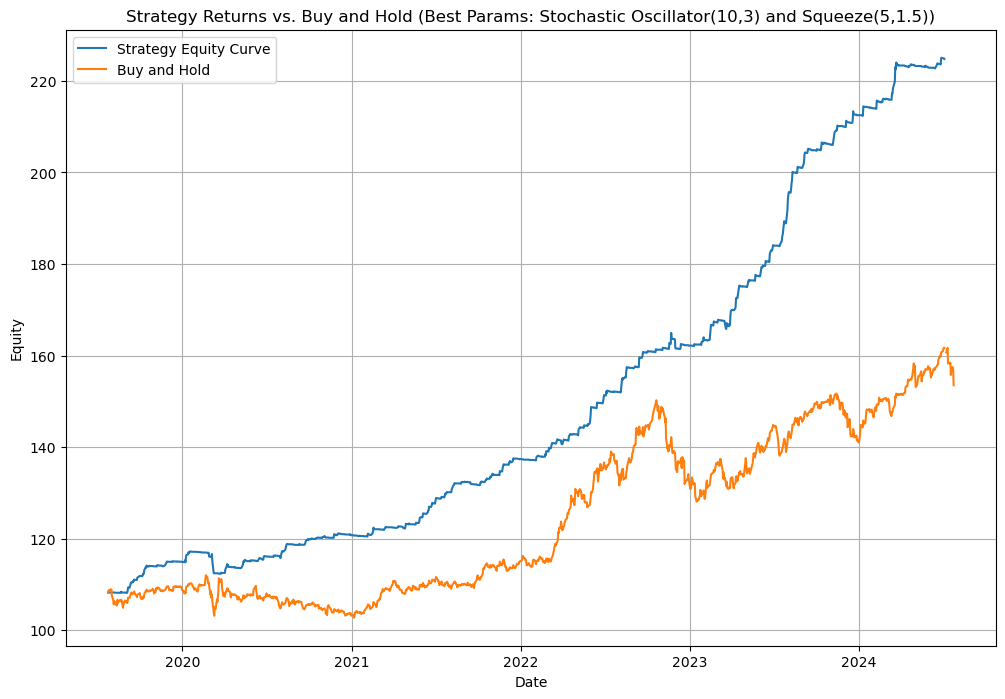

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Load data from CSV
def load_data(csv_file):
    data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
    return data

# Calculate Stochastic Oscillator
def calculate_stochastic(data, k_period=14, d_period=3):
    data['Lowest Low'] = data['Low'].rolling(window=k_period).min()
    data['Highest High'] = data['High'].rolling(window=k_period).max()
    data['%K'] = 100 * ((data['Close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low']))
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    return data

# Calculate Bollinger Bands for Squeeze Indicator
def calculate_squeeze(data, bb_period=20, bb_k=2):
    data['Middle Band'] = data['Close'].rolling(window=bb_period).mean()
    data['Upper Band'] = data['Middle Band'] + bb_k * data['Close'].rolling(window=bb_period).std()
    data['Lower Band'] = data['Middle Band'] - bb_k * data['Close'].rolling(window=bb_period).std()
    data['Bandwidth'] = (data['Upper Band'] - data['Lower Band']) / data['Middle Band']
    data['Squeeze'] = data['Bandwidth'] < data['Bandwidth'].rolling(window=bb_period).mean()
    return data

# Apply trading strategy based on Stochastic Oscillator and Squeeze Indicator
def apply_strategy(data, trade_cost_rate=0.0005):
    position = 0
    signals = []
    cash = 0
    equity = data['Close'].iloc[0]
    equity_curve = []  # Start equity list without initial equity

    for i in range(1, len(data)):
        buy_condition = data['%K'].iloc[i] > data['%D'].iloc[i] and data['%K'].iloc[i-1] <= data['%D'].iloc[i-1] and data['Squeeze'].iloc[i]
        sell_condition = data['%K'].iloc[i] < data['%D'].iloc[i] and data['%K'].iloc[i-1] >= data['%D'].iloc[i-1]
        
        if buy_condition:
            signals.append(1)  # Buy signal
            position = 1
            cash -= equity * trade_cost_rate
        elif sell_condition:
            signals.append(-1)  # Sell signal
            position = 0
            cash -= equity * trade_cost_rate
        else:
            signals.append(0)  # No signal
        
        equity = equity * (1 + (position * (data['Close'].iloc[i] - data['Close'].iloc[i-1]) / data['Close'].iloc[i-1]))
        equity_curve.append(equity + cash)
    
    result = data.iloc[1:].copy()  # align the lengths and create a copy to avoid SettingWithCopyWarning
    result['Position'] = signals
    result['Equity'] = equity_curve
    return result

# Plot results
def plot_results(data, strategy_name):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Equity'], label='Strategy Equity Curve')
    plt.plot((data['Close'] / data['Close'].iloc[0]) * data['Equity'].iloc[0], label='Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.title(f'Strategy Returns vs. Buy and Hold ({strategy_name})')
    plt.grid(True)
    plt.show()

def run_strategy(csv_file, k_period=14, d_period=3, bb_period=20, bb_k=2, trade_cost_rate=0.0005):
    data = load_data(csv_file)
    data = calculate_stochastic(data, k_period=k_period, d_period=d_period)
    data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'Stochastic Oscillator ({k_period},{d_period}) and Squeeze')
    return data

# Optimization method
def optimize_strategy(csv_file, k_period_range, d_period_range, bb_period_range, bb_k_range, trade_cost_rate=0.0005, top_n=5):
    results = []
    csv_data = load_data(csv_file)
    
    for k_period, d_period, bb_period, bb_k in product(k_period_range, d_period_range, bb_period_range, bb_k_range):
        data = csv_data.copy()
        data = calculate_stochastic(data, k_period=k_period, d_period=d_period)
        data = calculate_squeeze(data, bb_period=bb_period, bb_k=bb_k)
        data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
        final_equity = data['Equity'].iloc[-1]
        results.append((k_period, d_period, bb_period, bb_k, final_equity))

    # Sort results by final equity
    results.sort(key=lambda x: x[4], reverse=True)
    top_results = results[:top_n]

    # Print top results
    print("Top Optimization Results:")
    for result in top_results:
        print(f"K Period: {result[0]}, D Period: {result[1]}, BB Period: {result[2]}, BB k: {result[3]}, Final Equity: {result[4]:.2f}")

    # Plot the best result
    best_params = top_results[0]
    data = csv_data.copy()
    data = calculate_stochastic(data, k_period=best_params[0], d_period=best_params[1])
    data = calculate_squeeze(data, bb_period=best_params[2], bb_k=best_params[3])
    data = apply_strategy(data, trade_cost_rate=trade_cost_rate)
    plot_results(data, f'Best Params: Stochastic Oscillator({best_params[0]},{best_params[1]}) and Squeeze({best_params[2]},{best_params[3]})')

# Example usage
csv_file_path = 'USDJPY.csv'

# Running optimization with specified ranges
optimize_strategy(csv_file_path, 
                  k_period_range=range(10, 20, 1),  # Step size 1
                  d_period_range=range(3, 10, 1),  # Step size 1
                  bb_period_range=range(5, 50, 5),  # Step size 5
                  bb_k_range=[1.5, 2, 2.5, 3])  # Specific values


#run_strategy(csv_file_path, k_period=14, d_period=20, bb_period=50, bb_k=4, trade_cost_rate=0.001)
